In [327]:
import os
import numpy as np
import pandas as pd
import time
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.lines as mpl_lines
%matplotlib inline

## Resampling/Averaging

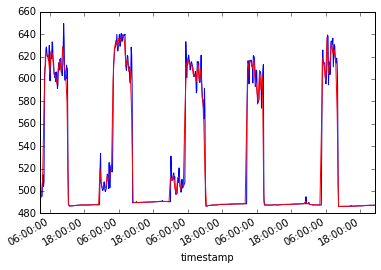

In [412]:
#!rsync 192.168.0.102:~/code/telemetry/bed/db/markII.csv db/bed.csv
old = pd.read_csv('../local/db/consolidation/markII.csv', names=['timestamp', 'wmin', 'wmax'])
old.timestamp = old.timestamp.astype('datetime64[s]')
old.set_index('timestamp', inplace=True)
old = old.tz_localize('UTC').tz_convert('Europe/Amsterdam')
#old = pd.concat([pd.DataFrame({'type': 6, 'value': old.wmax}), pd.DataFrame({'type': 7, 'value': old.wmax})])
old.mean(axis=1).resample('10min', how='mean').plot()
old.mean(axis=1).resample('30min', how='mean').plot(color='r')

## Spans for night-shading

In [383]:
def spans(df):
    drs = pd.date_range(df.index[0].normalize(),
                        df.index[-1].normalize(),
                        freq='D')
    dre = drs + pd.DateOffset(hour=8)
    return zip(drs, dre)

## ToastyTamandua data (old)

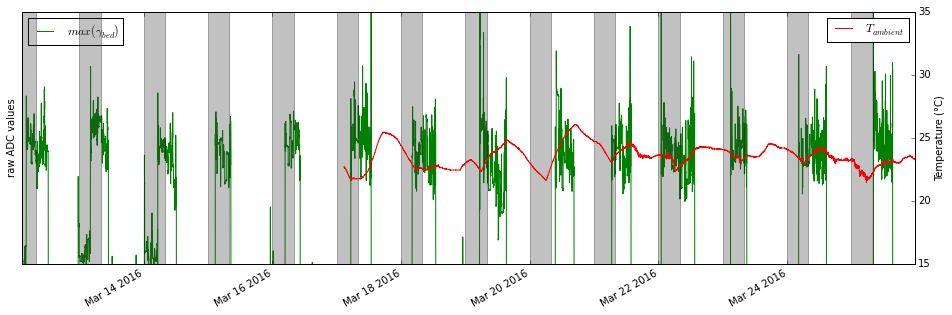

In [415]:
#!rsync -avh ToastyTamandua:~/code/telemetry/bed/db/rec.csv ../local/db/bed.csv

old = pd.read_csv('../local/db/consolidation/markII.csv', names=['timestamp', 'wmin', 'wmax'])
old.timestamp = old.timestamp.astype('datetime64[s]')
old.set_index('timestamp', inplace=True)
old = old.tz_localize('UTC').tz_convert('Europe/Amsterdam')
old = pd.concat([pd.DataFrame({'type': 6, 'value': old.wmin}), pd.DataFrame({'type': 7, 'value': old.wmax})])
    
df = pd.read_csv('../local/db/consolidation/bed.csv', names=['timestamp', 'type', 'value'])
df.timestamp = df.timestamp.astype('datetime64[s]')
df.set_index('timestamp', inplace=True)
#df = df.drop(['timestamp'])
df = df.tz_localize('UTC').tz_convert('Europe/Amsterdam')

df.type.loc[df.type=='strain_lo'] = 6
df.type.loc[df.type=='strain_hi'] = 7
df.type.loc[df.type=='temp'] = 8

df = pd.concat([old, df])
df.type.astype('uint8')

fig = plt.figure()
axes = fig.add_subplot(111)
axes_r = axes.twinx()

# night background
for span in spans(df):
    plt.axvspan(span[0], span[1], facecolor='0.2', alpha=0.3)

groups = df.groupby('type')
groups.get_group(8).value.plot(ax=axes_r, style='r', label=r'$T_{ambient}$')
#groups.get_group(6).value.resample('30s').plot(ax=axes, style='b', label='strain_lo')
groups.get_group(7).value.resample('1min').plot(ax=axes, style='g', label=r'$max(\gamma_{bed})$')

axes_r.set_ylim((15, 35))
axes_r.set_ylabel(u'Temperature (°C)')
axes_r.legend()

axes.set_ylim((500, 750))
axes.legend(loc=2)
axes.set_xlabel('')
axes.set_yticks([])
axes.set_ylabel(u'raw ADC values')

fig.set_size_inches(16, 5)

## VersedSquid (chuck)

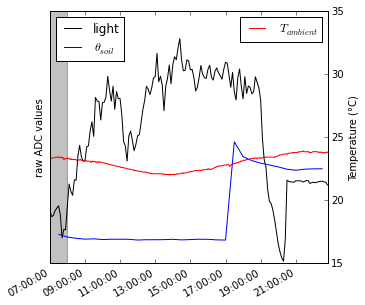

In [416]:
#!rsync -avh VersedSquid:~/code/telemetry/local/db/ ../local/db/
df = pd.read_csv('../local/db/consolidation/chuck_2016-03-28.csv', names=['timestamp', 'type', 'value'])
df.timestamp = df.timestamp.astype('datetime64[s]')
df.set_index('timestamp', inplace=True)
df = df.drop(['timestamp'])
df = df.tz_localize('UTC').tz_convert('Europe/Amsterdam')
df.type.loc[df.type=='ds_temp'] = 1
df.type.loc[df.type=='light'] = 2
df.type.loc[df.type=='soil'] = 3;
df.type.astype('uint8');

fig = plt.figure()
axes = fig.add_subplot(111)

# night background
for span in spans(df):
    plt.axvspan(span[0], span[1], facecolor='0.2', alpha=0.3)

groups = df.groupby('type')
groups.get_group(2).value.resample('6min').plot(ax=axes, style='k', label=r'light')
groups.get_group(3).value.plot(ax=axes, style='b', label=r'$\theta_{soil}$')

axes.set_ylim((0, 1023))
# handles, labels = axes.get_legend_handles_labels()
# handles.append(ep_artist)
# axes.legend(handles=handles, loc=2)
axes.legend(loc=2)
axes.set_xlabel('')
axes.set_yticks([])
axes.set_ylabel(u'raw ADC values')

# temp
axes_r = axes.twinx()
groups.get_group(1).value.plot(ax=axes_r, style='r', label=r'$T_{ambient}$')

axes_r.set_ylim((15, 35))
axes_r.set_ylabel(u'Temperature (°C)')
axes_r.legend()


delta = (df.index[-1] - df.index[0]) / pd.Timedelta('1 Day')
width = delta*0.944881889764*8

fig.set_size_inches(width, 5)

## RandyDolphin data (new, with motion, slow Fs)

receiving incremental file list
bed_2016-03-26.csv

sent 5.57K bytes  received 11.10K bytes  33.34K bytes/sec
total size is 853.67K  speedup is 51.22


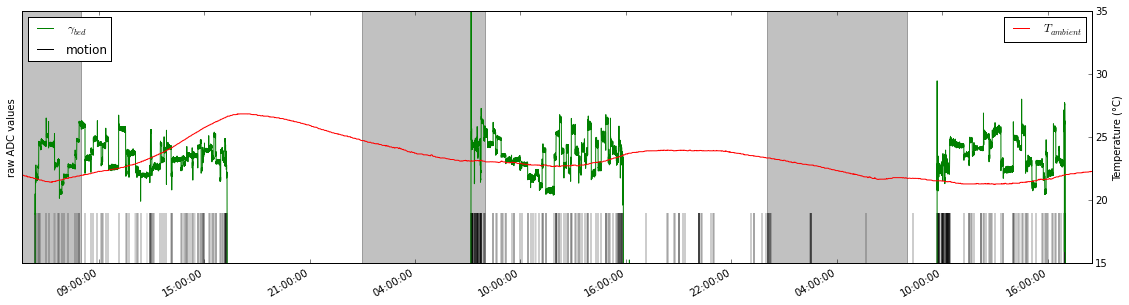

In [402]:
!rsync -avh RandyDolphin:~/code/telemetry/local/db/ ../local/db/
df = pd.read_csv('../local/db/bed_2016-03-26.csv', names=['timestamp', 'type', 'value'])
df.timestamp = df.timestamp.astype('datetime64[s]')
df.set_index('timestamp', inplace=True)
df = df.tz_localize('UTC').tz_convert('Europe/Amsterdam')
df.type.loc[df.type=='strain'] = 7
df.type.loc[df.type=='temp'] = 8
df.type.loc[df.type=='motion'] = 9;
df.type.astype('uint8');
df.head()

fig = plt.figure()
axes = fig.add_subplot(111)
# night background
for span in spans(df):
    plt.axvspan(span[0], span[1], facecolor='0.2', alpha=0.3)

groups = df.groupby('type')
groups.get_group(7).value.plot(ax=axes, style='g', label=r'$\gamma_{bed}$')
plt.eventplot(groups.get_group(9).value.index, linewidths=.2, colors='k', linelengths=50, lineoffsets=525)
ep_artist = mpl_lines.Line2D([], [], color='k', label=r'motion')
axes.set_ylim((500, 750))
handles, labels = axes.get_legend_handles_labels()
handles.append(ep_artist)
axes.legend(handles=handles, loc=2)
axes.set_xlabel('')
axes.set_yticks([])
axes.set_ylabel(u'raw ADC values')

# temp
axes_r = axes.twinx()
groups.get_group(8).value.plot(ax=axes_r, style='r', label=r'$T_{ambient}$')

axes_r.set_ylim((15, 35))
axes_r.set_ylabel(u'Temperature (°C)')
axes_r.legend()

delta = (df.index[-1] - df.index[0]) / pd.Timedelta('1 Day')
width = delta*0.944881889764*8

fig.set_size_inches(width, 5)



13